In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

plt.rcParams.update(
    {
        "font.size": 25,
        "figure.figsize": (14, 7),
        "axes.grid": True,
        "grid.color": "#93a1a1",
        "grid.alpha": 0.3,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

Using device cuda.


## Load and preprocess data

In [2]:
# Download data
!wget https://gitlab.com/max.cohen/ateliers-algos/-/raw/main/dataset_DPE.csv

--2023-05-12 05:59:15--  https://gitlab.com/max.cohen/ateliers-algos/-/raw/main/dataset_DPE.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2021731 (1.9M) [text/plain]
Saving to: ‘dataset_DPE.csv’

dataset_DPE.csv     100%[===================>]   1.93M  --.-KB/s    in 0.07s   

2023-05-12 05:59:15 (27.7 MB/s) - ‘dataset_DPE.csv’ saved [2021731/2021731]



In [3]:
# Load data in a dataframe
df = pd.read_csv("dataset_DPE.csv")[:10000]
df

,Etiquette_GES,Etiquette_DPE,Année_construction,Hauteur_sous-plafond,Surface_habitable_logement,N°_région_(BAN),Conso_5_usages_é_finale
0,C,D,1945.0,2.9,220.8,27.0,37940.5
1,D,D,1948.0,2.5,36.4,11.0,8212.5
2,D,D,1948.0,2.5,49.0,53.0,9546.3
3,F,G,1947.0,2.5,47.0,11.0,18898.9
4,D,D,1948.0,2.5,49.0,53.0,9546.3
...,...,...,...,...,...,...,...
9995,B,D,2006.0,2.5,19.1,84.0,1971.9
9996,D,D,1830.0,2.5,109.0,28.0,5823.6
9997,D,G,1947.0,2.6,18.8,11.0,7675.7
9998,B,D,1994.0,2.5,16.5,11.0,1629.5


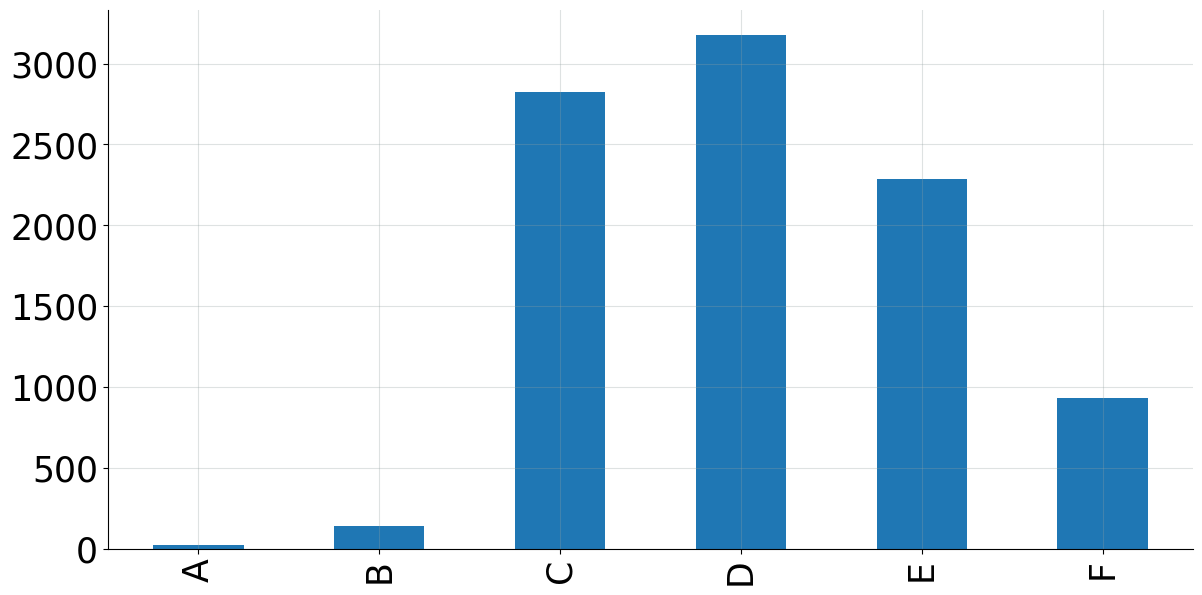

In [4]:
# Visualize the DPE notation distribution in the dataset
df["Etiquette_DPE"].value_counts().loc[['A', 'B', 'C', 'D', 'E', 'F']].plot(kind="bar");

In [5]:
class DatasetDPE(Dataset):
    """Torch Dataset for preprocessing and accessing the dataframe.

    In the ``__init__`` function, we preprocess the dataframe by
     - converting DPE notations to numeric classes
     - storing input variables and targets to tensors
     - normalizing the input tensor

    The two additionnal ``__len__`` and ``__getitem__`` functions allows for
    accessing samples of the dataset, and are used by the Torch Dataloaders.
    """
    def __init__(self, df: pd.DataFrame):
        super().__init__()
        # Use a numeric classification for DPE (i.e. A, B, C -> 0, 1, 2)
        df["DPE_class"] = df["Etiquette_DPE"].apply(
            lambda etiquette: ord(etiquette)-65
        )
        # Convert columns to input tensors X and target y
        self.X = torch.tensor(df[[
            'Année_construction',
            'Hauteur_sous-plafond',
            'N°_région_(BAN)',
            'Surface_habitable_logement',
            'Conso_5_usages_é_finale',
        ]].values, dtype=torch.float32)
        self.y = torch.tensor(df["DPE_class"].values, dtype=torch.long)
        # Normalize input data
        self.X = (self.X - self.X.min(axis=0)[0]) / (self.X.max(axis=0)[0] - self.X.min(axis=0)[0])
        
    def __len__(self) -> int:
        return len(self.X)
    
    def __getitem__(self, idx: int) -> tuple[torch.tensor]:
        return (self.X[idx], self.y[idx])
  
# Instantiate the dataset
dataset = DatasetDPE(df)
# Setup a dataloader, specify the batch size
dataloader = DataLoader(dataset, batch_size=16, num_workers=2, shuffle=True)

## Define the model

The aim is to predict the class of each data. **Softmax regression** provides a model for the probability that an input $x$ is associated with each class.  

In the case where there are $K$ classes, we write, for all $1\leq k \leq K$:
$$
\mathbb{P}(Y=k|X) = \frac{\exp\left(w_k^\top X\right)}{\sum_{j=1}^K\exp\left(w_j^\top X\right)}
$$
where $\omega_j$, $1\leq j\leq K$, are the unknown parameter to be estimated.
Stochastic gradient descent and its accelerated versions can be used to learn these parameters using small batches of data.   

To illustrate gradient-based optimization procedures we propose **dense neural networks** to introduce non linearities. 
The Multi-layer Perceptron (MLP) or Feed Forward Neural Network (FFNN) uses $L$ layers to produce the output. Define all layers as follows.
\begin{align*}
h_{\theta}^0(X) &= X\,,\\
z_{\theta}^k(X)  &= b^k + W^kh_{\theta}^{k-1}(X)\quad \mathrm{for\;all\;} 1\leqslant k\leqslant L\,,\\
h_{\theta}^k(X)  &= \varphi_k(z_{\theta}^{k}(X))\quad \mathrm{for\;all\;}1\leqslant k\leqslant L\,,
\end{align*}
where $b^1\in\mathbb{R}^{d_1}$, $W^1\in\mathbb{R}^{d_1\times d}$ and for all $2\leqslant k\leqslant L$, $b^k\in\mathbb{R}^{d_k}$, $W^k\in\mathbb{R}^{d_k\times d_{k-1}}$. For all $1\leqslant k\leqslant L$, $\varphi_k: \mathbb{R}^{d_k} \to \mathbb{R}^{d_k}$ is a nonlinear activation function. Let $\theta = \{b^1,W^1,\ldots,b^L,W^L\}$ be the unknown parameters of the MLP and $f_{\theta}(x) = h_{\theta}^L(x)$ be the output layer of the MLP. As there is no modelling assumptions anymore, virtually any activation functions $\varphi^m$, $1\leqslant m\leqslant L-1$ may be used. In this section, it is assumed that these intermediate activation functions apply elementwise and, with a minor abuse of notations, we write for all $1\leqslant m\leqslant L-1$ and all $z\in\mathbb{R}^{d_m}$,
$$
\varphi^m(z) = (\varphi^m(z_1),\ldots, \varphi^m(z_{d_m}))\,,
$$
with $\varphi^m: \mathbb{R}\to \mathbb{R}$ the seleced scalar activation function. The rectified linear unit (RELU) activation function $x \mapsto \mathrm{max}(0,x)$ and its extensions are the default recommendation in modern implementations.

In our case,  The output $h_{\theta}^L(x)$ is the estimate of the probability that the class is  $k$ for all $1\leqslant k\leqslant M$, given the input $x$. The common choice in this case is the softmax function.

Illustration of a layer (from IP Paris M2 lecture notes).
![](https://drive.google.com/uc?export=view&id=1fT1zNeMxLsoxRKDIKGq4zGYhn8FP-Uk7)


Illustration of dense network (from IP Paris M2 lecture notes).
![](https://drive.google.com/uc?export=view&id=1rZCDI4Yvb5vEj1VygPPxc3_kVUgE0-vJ)


In [ ]:
# We define a model with a hidden state and a ReLU non linearity
num_hidden = 16
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=5, out_features=num_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=num_hidden, out_features=len(df["DPE_class"].unique())),
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
epochs = 50
hist_loss = []
# Iterate through the epochs
for _ in tqdm.tqdm(range(epochs)):
    running_loss = 0
    # Iterate through each training sample in the dataset
    for X, y in dataloader:
        # Move X and y to the device
        X = X.to(device)
        y = y.to(device)
        # Compute the prediction error
        loss = loss_function(model(X), y)
        # Backpropagate the error
        optimizer.zero_grad()
        loss.backward()
        # Run one gradient step
        optimizer.step()
        # Log the current error
        running_loss += loss.item()
    hist_loss.append(running_loss / len(dataloader))

100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


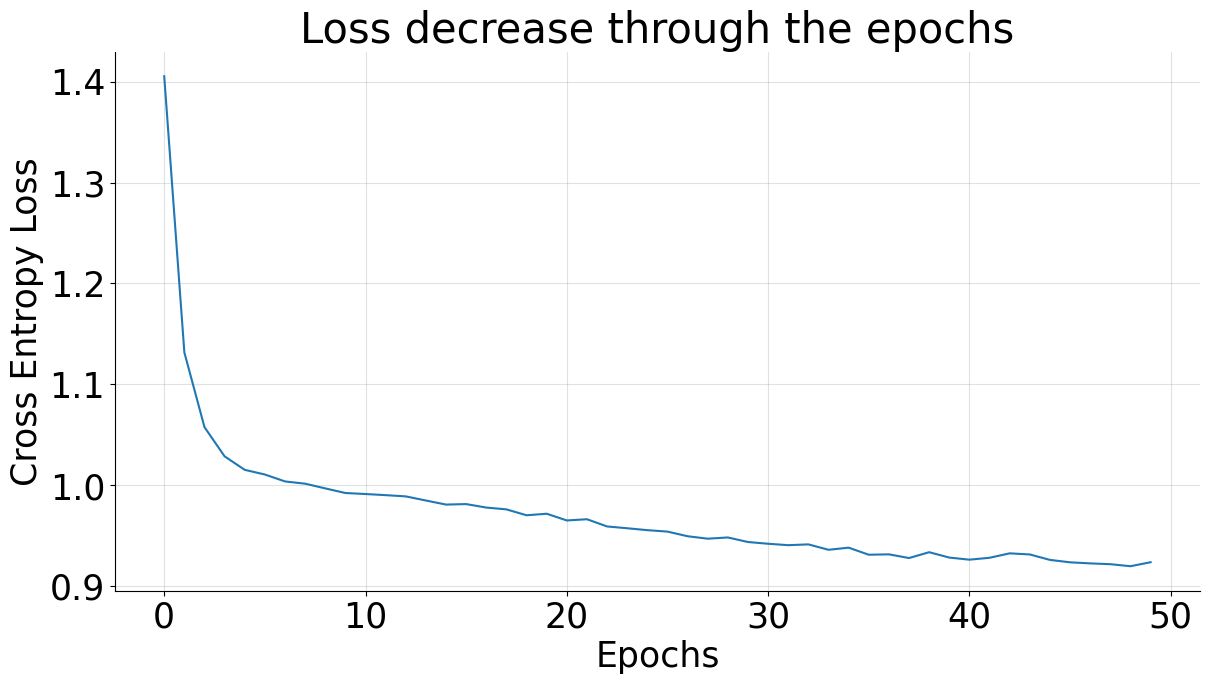

In [ ]:
plt.title("Loss decrease through the epochs")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(hist_loss);

In [ ]:
# Compute the accuracy on the entire dataset
accuracy = 0
for X, y in dataloader:
    # Move X and y to device
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        prediction = torch.nn.functional.softmax(
            model(X), dim=-1
        ).argmax(dim=-1)
        accuracy += (prediction == y).sum().item()
print(f"Accuracy: {accuracy / len(dataset):.2f}")

Accuracy: 0.65


In [ ]:
###
# A compléter
# 1 - Créer un modèle avec deux couches intermédiares 
# 2 - Comparer la convergence de l'apprentissage du modèle avec SGD et ADAM
###